In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
import matplotlib.pyplot as plt

train_df = pd.read_csv("../../datasets/delhi_climate_train.csv")
test_df = pd.read_csv("../../datasets/delhi_climate_test.csv")
print("Length of train", len(train_df))
print("Length of test", len(test_df))
print(train_df.head())
train_df.describe()

Length of train 1462
Length of test 114
         date   meantemp   humidity  wind_speed  meanpressure
0  2013-01-01  10.000000  84.500000    0.000000   1015.666667
1  2013-01-02   7.400000  92.000000    2.980000   1017.800000
2  2013-01-03   7.166667  87.000000    4.633333   1018.666667
3  2013-01-04   8.666667  71.333333    1.233333   1017.166667
4  2013-01-05   6.000000  86.833333    3.700000   1016.500000


,meantemp,humidity,wind_speed,meanpressure
count,1462.000000,1462.000000,1462.000000,1462.000000
mean,25.495521,60.771702,6.802209,1011.104548
std,7.348103,16.769652,4.561602,180.231668
min,6.000000,13.428571,0.000000,-3.041667
25%,18.857143,50.375000,3.475000,1001.580357
50%,27.714286,62.625000,6.221667,1008.563492
75%,31.305804,72.218750,9.238235,1014.944901
max,38.714286,100.000000,42.220000,7679.333333


In [2]:
train_df["date"] = pd.to_datetime(train_df["date"])
train_df.set_index("date", inplace=True)
test_df["date"] = pd.to_datetime(test_df["date"])
test_df.set_index("date", inplace=True)


Text(0.5, 0.98, "Test data's graph")

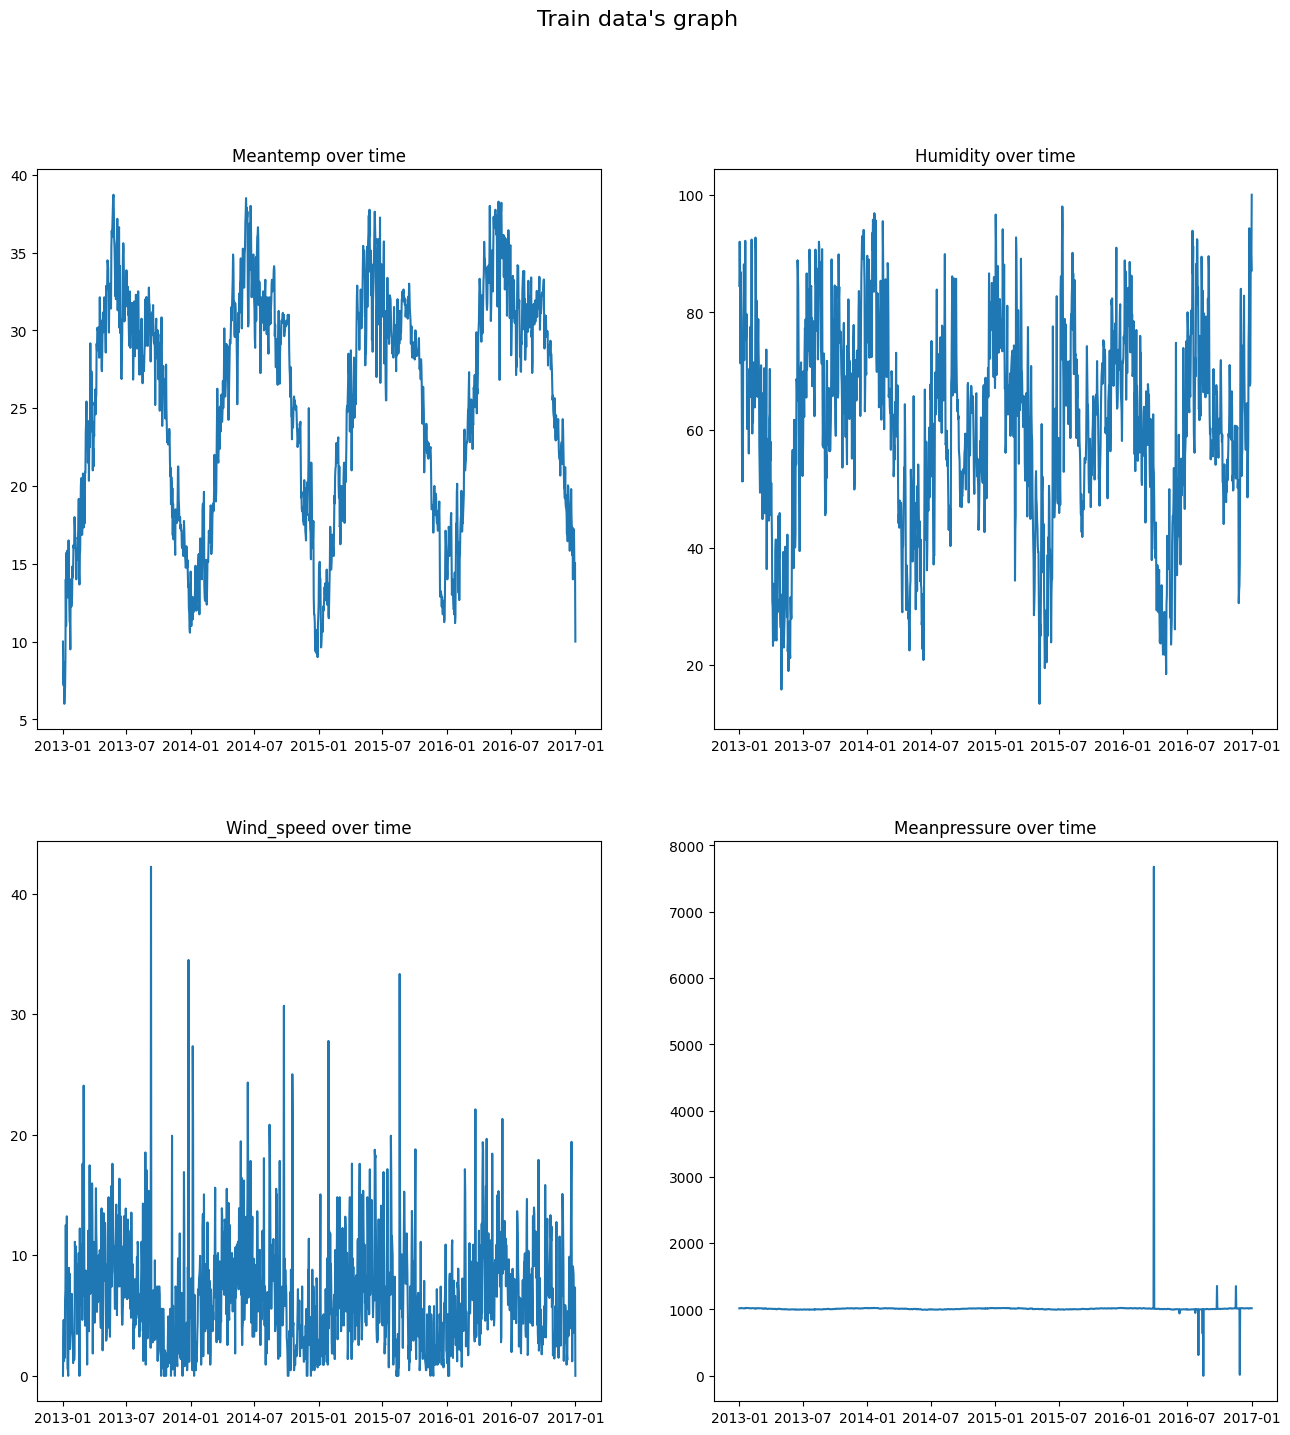

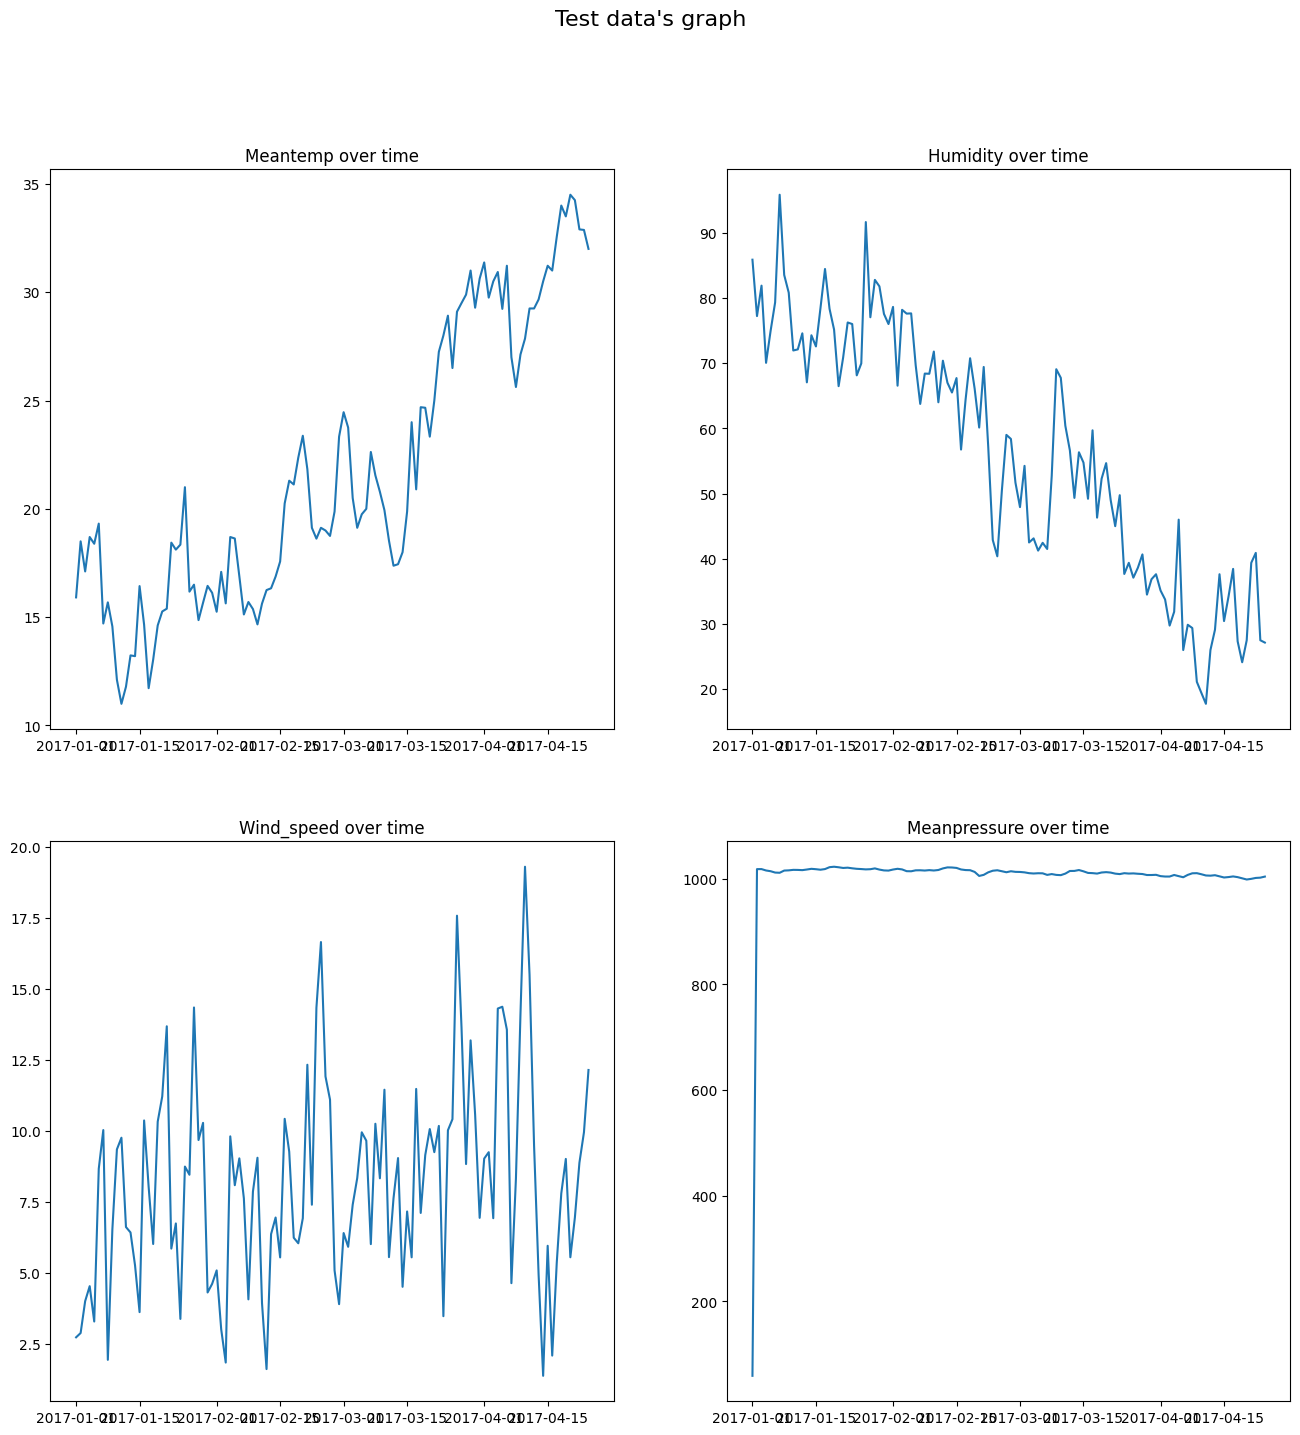

In [3]:
fig, (axs) = plt.subplots(2, 2, figsize=(16, 16))
# fig(figsize=(16, 16))
axs[0, 0].plot(train_df["meantemp"])
axs[0, 0].set_title("Meantemp over time")
axs[0, 1].plot(train_df["humidity"])
axs[0, 1].set_title("Humidity over time")
axs[1, 0].plot(train_df["wind_speed"])
axs[1, 0].set_title("Wind_speed over time")
axs[1, 1].plot(train_df["meanpressure"])
axs[1, 1].set_title("Meanpressure over time")
fig.suptitle("Train data's graph", fontsize=16)

fig, (axs) = plt.subplots(2, 2, figsize=(16, 16))

axs[0, 0].plot(test_df["meantemp"])
axs[0, 0].set_title("Meantemp over time")
axs[0, 1].plot(test_df["humidity"])
axs[0, 1].set_title("Humidity over time")
axs[1, 0].plot(test_df["wind_speed"])
axs[1, 0].set_title("Wind_speed over time")
axs[1, 1].plot(test_df["meanpressure"])
axs[1, 1].set_title("Meanpressure over time")
fig.suptitle("Test data's graph", fontsize=16)

# We can some seasonality with meantemp, windspeed, and humidity
# Apparantly there's a lot of white noise
# There aren't a lot of trends
# A few variations, especially for windspeed and meanpressure  

In [4]:
from sklearn.preprocessing import MinMaxScaler
# Choosing prediction column 
n_cols = 1
dataset = train_df["meantemp"]
dataset = pd.DataFrame(dataset)

data = dataset.values
scaler = MinMaxScaler(feature_range= (0, 1))
scaled_data = scaler.fit_transform(np.array(data))
train_size = int(len(scaled_data) * 0.75)
train_data = scaled_data[0:train_size, :]
val_data = scaled_data[train_size:, :]

test_dataset = test_df["meantemp"]
test_dataset = pd.DataFrame(test_dataset)
data = test_dataset.values
test_data = scaler.fit_transform(np.array(data))

patch_size5 = 5
patch_size20 = 20
patch_size60 = 60

def getDataWithPatch(patch, stride, data_list):
    
    x = []
    y = []
    for i in range(patch, len(data_list), stride):
        x.append(data_list[i-patch:i, :n_cols])
        y.append(data_list[i, :n_cols])
    
    # Convert to numpy array
    x, y = np.array(x), np.array(y)
    # Reshaping the input to (n_samples, time_steps, n_feature)
    x = np.reshape(x, (x.shape[0], x.shape[1], n_cols))
    return x, y
    
# For now, assume a stride of 0 (no overlaps for now)
x_train, y_train = getDataWithPatch(1, 1, train_data)
x_train_p5, y_train_p5 = getDataWithPatch(patch_size5, patch_size5, train_data)
x_train_p20, y_train_p20 = getDataWithPatch(patch_size20, patch_size20, train_data)
x_train_p60, y_train_p60 = getDataWithPatch(patch_size60, patch_size60, train_data)

x_val, y_val = getDataWithPatch(1, 1, val_data)
x_val_p5, y_val_p5 = getDataWithPatch(patch_size5, patch_size5, val_data)
x_val_p20, y_val_p20 = getDataWithPatch(patch_size20, patch_size20, val_data)
x_val_p60, y_val_p60 = getDataWithPatch(patch_size60, patch_size60, val_data)

x_test, y_test = getDataWithPatch(1, 1, test_data)
x_test_p5, y_test_p5 = getDataWithPatch(patch_size5, patch_size5, test_data)
x_test_p20, y_test_p20 = getDataWithPatch(patch_size20, patch_size20, test_data)
x_test_p60, y_test_p60 = getDataWithPatch(patch_size60, patch_size60, test_data)

In [5]:

from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.layers import Dense, LSTM, Dropout
model = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train.shape[1], n_cols)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(n_cols)
])

model.compile(optimizer= 'adam', loss= 'mse' , metrics= "mean_absolute_error")
model.summary()

model_p5 = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train_p5.shape[1], n_cols)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(n_cols)
])

model_p5.compile(optimizer= 'adam', loss= 'mse' , metrics= "mean_absolute_error")
model_p5.summary()

model_p20 = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train_p20.shape[1], n_cols)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(n_cols)
])

model_p20.compile(optimizer= 'adam', loss= 'mse' , metrics= "mean_absolute_error")
model_p20.summary()

model_p60 = Sequential([
    LSTM(50, return_sequences= True, input_shape= (x_train_p60.shape[1], n_cols)),
    LSTM(64, return_sequences= False),
    Dense(32),
    Dense(16),
    Dense(n_cols)
])

model_p60.compile(optimizer= 'adam', loss= 'mse' , metrics= "mean_absolute_error")
model_p60.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 50)             10400     
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 1)                 17        
                                                                 
Total params: 42,465
Trainable params: 42,465
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
______________________________

In [6]:
history = model.fit(x_train, y_train, epochs= 100, batch_size= 32)


Epoch 1/100
35/35 [==============================] - 4s 5ms/step - loss: 0.1227 - mean_absolute_error: 0.2740
Epoch 2/100
35/35 [==============================] - 0s 5ms/step - loss: 0.0269 - mean_absolute_error: 0.1395
Epoch 3/100
35/35 [==============================] - 0s 4ms/step - loss: 0.0119 - mean_absolute_error: 0.0885
Epoch 4/100
35/35 [==============================] - 0s 4ms/step - loss: 0.0033 - mean_absolute_error: 0.0443
Epoch 5/100
35/35 [==============================] - 0s 4ms/step - loss: 0.0028 - mean_absolute_error: 0.0395
Epoch 6/100
35/35 [==============================] - 0s 4ms/step - loss: 0.0029 - mean_absolute_error: 0.0405
Epoch 7/100
35/35 [==============================] - 0s 4ms/step - loss: 0.0027 - mean_absolute_error: 0.0391
Epoch 8/100
35/35 [==============================] - 0s 4ms/step - loss: 0.0028 - mean_absolute_error: 0.0398
Epoch 9/100
35/35 [==============================] - 0s 5ms/step - loss: 0.0028 - mean_absolute_error: 0.0398
Epoch 10/1

In [7]:
history_p5 = model_p5.fit(x_train_p5, y_train_p5, epochs= 100, batch_size= 32)

Epoch 1/100
7/7 [==============================] - 3s 10ms/step - loss: 0.2342 - mean_absolute_error: 0.4304
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 0.0321 - mean_absolute_error: 0.1487
Epoch 3/100
7/7 [==============================] - 0s 9ms/step - loss: 0.0280 - mean_absolute_error: 0.1377
Epoch 4/100
7/7 [==============================] - 0s 11ms/step - loss: 0.0171 - mean_absolute_error: 0.1110
Epoch 5/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0139 - mean_absolute_error: 0.1000
Epoch 6/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0112 - mean_absolute_error: 0.0843
Epoch 7/100
7/7 [==============================] - 0s 7ms/step - loss: 0.0087 - mean_absolute_error: 0.0756
Epoch 8/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0076 - mean_absolute_error: 0.0722
Epoch 9/100
7/7 [==============================] - 0s 6ms/step - loss: 0.0061 - mean_absolute_error: 0.0625
Epoch 10/100
7/7 [=======

In [8]:
history_p20 = model_p20.fit(x_train_p20, y_train_p20, epochs= 100, batch_size= 32)

Epoch 1/100
2/2 [==============================] - 3s 26ms/step - loss: 0.3531 - mean_absolute_error: 0.5488
Epoch 2/100
2/2 [==============================] - 0s 26ms/step - loss: 0.1264 - mean_absolute_error: 0.3112
Epoch 3/100
2/2 [==============================] - 0s 18ms/step - loss: 0.0188 - mean_absolute_error: 0.1166
Epoch 4/100
2/2 [==============================] - 0s 17ms/step - loss: 0.0586 - mean_absolute_error: 0.2207
Epoch 5/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0547 - mean_absolute_error: 0.2142
Epoch 6/100
2/2 [==============================] - 0s 17ms/step - loss: 0.0171 - mean_absolute_error: 0.1055
Epoch 7/100
2/2 [==============================] - 0s 19ms/step - loss: 0.0123 - mean_absolute_error: 0.0931
Epoch 8/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0237 - mean_absolute_error: 0.1319
Epoch 9/100
2/2 [==============================] - 0s 16ms/step - loss: 0.0295 - mean_absolute_error: 0.1488
Epoch 10/100
2/2 [=

In [9]:
history_p60 = model_p60.fit(x_train_p60, y_train_p60, epochs= 100, batch_size= 32)

Epoch 1/100
1/1 [==============================] - 4s 4s/step - loss: 0.4835 - mean_absolute_error: 0.6455
Epoch 2/100
1/1 [==============================] - 0s 60ms/step - loss: 0.3008 - mean_absolute_error: 0.5008
Epoch 3/100
1/1 [==============================] - 0s 41ms/step - loss: 0.1747 - mean_absolute_error: 0.3751
Epoch 4/100
1/1 [==============================] - 0s 43ms/step - loss: 0.0862 - mean_absolute_error: 0.2657
Epoch 5/100
1/1 [==============================] - 0s 39ms/step - loss: 0.0310 - mean_absolute_error: 0.1608
Epoch 6/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0140 - mean_absolute_error: 0.0902
Epoch 7/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0359 - mean_absolute_error: 0.1608
Epoch 8/100
1/1 [==============================] - 0s 38ms/step - loss: 0.0610 - mean_absolute_error: 0.2272
Epoch 9/100
1/1 [==============================] - 0s 37ms/step - loss: 0.0592 - mean_absolute_error: 0.2238
Epoch 10/100
1/1 [===

Text(0, 0.5, 'loss')

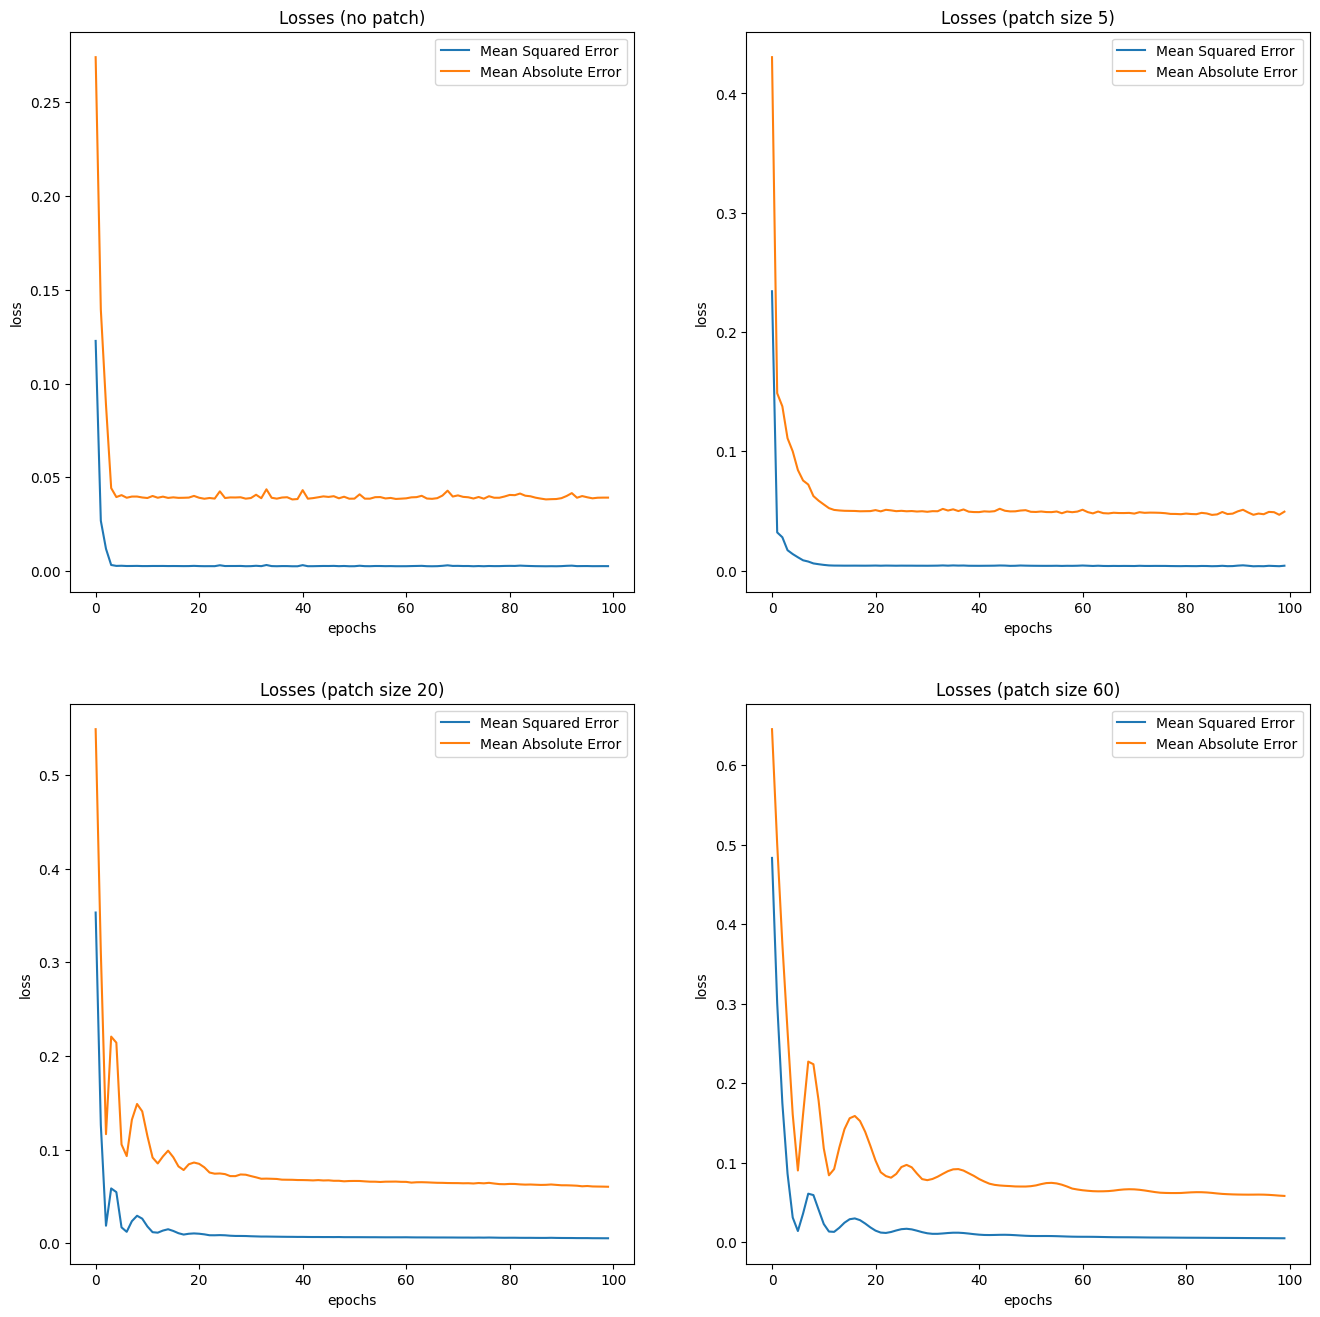

In [10]:

fig, (axs) = plt.subplots(2, 2, figsize=(16, 16))
# fig(figsize=(16, 16))
axs[0, 0].plot(history.history["loss"])
axs[0, 0].plot(history.history["mean_absolute_error"])
axs[0, 0].set_title("Losses (no patch)")
axs[0, 0].legend(['Mean Squared Error','Mean Absolute Error'])
axs[0, 0].set_xlabel("epochs")
axs[0, 0].set_ylabel("loss")


axs[0, 1].plot(history_p5.history["loss"])
axs[0, 1].plot(history_p5.history["mean_absolute_error"])
axs[0, 1].set_title("Losses (patch size 5)")
axs[0, 1].legend(['Mean Squared Error','Mean Absolute Error'])
axs[0, 1].set_xlabel("epochs")
axs[0, 1].set_ylabel("loss")


axs[1, 0].plot(history_p20.history["loss"])
axs[1, 0].plot(history_p20.history["mean_absolute_error"])
axs[1, 0].set_title("Losses (patch size 20)")
axs[1, 0].legend(['Mean Squared Error','Mean Absolute Error'])
axs[1, 0].set_xlabel("epochs")
axs[1, 0].set_ylabel("loss")


axs[1, 1].plot(history_p60.history["loss"])
axs[1, 1].plot(history_p60.history["mean_absolute_error"])
axs[1, 1].set_title("Losses (patch size 60)")
axs[1, 1].legend(['Mean Squared Error','Mean Absolute Error'])
axs[1, 1].set_xlabel("epochs")
axs[1, 1].set_ylabel("loss")


In [11]:
train_pred = scaler.inverse_transform(model.predict(x_train))
train_pred_p5 = scaler.inverse_transform(model_p5.predict(x_train_p5))
train_pred_p20 = scaler.inverse_transform(model_p20.predict(x_train_p20))
train_pred_p60 = scaler.inverse_transform(model_p60.predict(x_train_p60))

val_pred = scaler.inverse_transform(model.predict(x_val))
val_pred_p5 = scaler.inverse_transform(model_p5.predict(x_val_p5))
val_pred_p20 = scaler.inverse_transform(model_p20.predict(x_val_p20))
val_pred_p60 = scaler.inverse_transform(model_p60.predict(x_val_p60))

test_pred = scaler.inverse_transform(model.predict(x_test))
test_pred_p5 = scaler.inverse_transform(model_p5.predict(x_test_p5))
test_pred_p20 = scaler.inverse_transform(model_p20.predict(x_test_p20))
test_pred_p60 = scaler.inverse_transform(model_p60.predict(x_test_p60))

y_train = scaler.inverse_transform(y_train)
y_train_p5 = scaler.inverse_transform(y_train_p5)
y_train_p20 = scaler.inverse_transform(y_train_p20)
y_train_p60 = scaler.inverse_transform(y_train_p60)

y_val = scaler.inverse_transform(y_val)
y_val_p5 = scaler.inverse_transform(y_val_p5)
y_val_p20 = scaler.inverse_transform(y_val_p20)
y_val_p60 = scaler.inverse_transform(y_val_p60)

y_test = scaler.inverse_transform(y_test)
y_test_p5 = scaler.inverse_transform(y_test_p5)
y_test_p20 = scaler.inverse_transform(y_test_p20)
y_test_p60 = scaler.inverse_transform(y_test_p60)

1/1 [==============================] - 0s 55ms/step


In [12]:
from sklearn.metrics import mean_squared_error

train_rmse = mean_squared_error(y_train, train_pred,  squared=False)
train_rmse_p5 = mean_squared_error(y_train_p5, train_pred_p5,  squared=False)
train_rmse_p20 = mean_squared_error(y_train_p20, train_pred_p20,  squared=False)
train_rmse_p60 = mean_squared_error(y_train_p60, train_pred_p60,  squared=False)

val_rmse = mean_squared_error(y_val, val_pred,  squared=False)
val_rmse_p5 = mean_squared_error(y_val_p5, val_pred_p5,  squared=False)
val_rmse_p20 = mean_squared_error(y_val_p20, val_pred_p20,  squared=False)
val_rmse_p60 = mean_squared_error(y_val_p60, val_pred_p60,  squared=False)

test_rmse = mean_squared_error(y_test, test_pred,  squared=False)
test_rmse_p5 = mean_squared_error(y_test_p5, test_pred_p5,  squared=False)
test_rmse_p20 = mean_squared_error(y_test_p20, test_pred_p20,  squared=False)
test_rmse_p60 = mean_squared_error(y_test_p60, test_pred_p60,  squared=False)

print(f"Train RMSE (no patch) : {train_rmse}")
print(f"Val RMSE (no patch) : {val_rmse}")
print(f"Test RMSE (no patch) : {test_rmse}")
print("------------------------------")
print(f"Train RMSE (patch size 5) : {train_rmse_p5}")
print(f"Val RMSE (patch size 5) : {val_rmse_p5}")
print(f"Test RMSE (patch size 5) : {test_rmse_p5}")
print("------------------------------")
print(f"Train RMSE (patch size 20) : {train_rmse_p20}")
print(f"Val RMSE (patch size 20) : {val_rmse_p20}")
print(f"Test RMSE (patch size 20) : {test_rmse_p20}")
print("------------------------------")
print(f"Train RMSE (patch size 60) : {train_rmse_p60}")
print(f"Val RMSE (patch size 60) : {val_rmse_p60}")
print(f"Test RMSE (patch size 60) : {test_rmse_p60}")

Train RMSE (no patch) : 1.203578931764765
Val RMSE (no patch) : 1.1923849591029483
Test RMSE (no patch) : 1.6903422505825247
------------------------------
Train RMSE (patch size 5) : 1.4705552105743085
Val RMSE (patch size 5) : 1.4069358567335484
Test RMSE (patch size 5) : 2.191306951385399
------------------------------
Train RMSE (patch size 20) : 1.7237036549251563
Val RMSE (patch size 20) : 1.3931089358876847
Test RMSE (patch size 20) : 2.9427370604180827
------------------------------
Train RMSE (patch size 60) : 1.6325542328879024
Val RMSE (patch size 60) : 1.3179284030022715
Test RMSE (patch size 60) : 3.051385879516605


In [13]:
train_p = pd.DataFrame(data={'Predictions':train_pred.flatten(), 'Actuals':y_train.flatten()})
train_p5 = pd.DataFrame(data={'Predictions':train_pred_p5.flatten(), 'Actuals':y_train_p5.flatten()})
train_p20 = pd.DataFrame(data={'Predictions':train_pred_p20.flatten(), 'Actuals':y_train_p20.flatten()})
train_p60 = pd.DataFrame(data={'Predictions':train_pred_p60.flatten(), 'Actuals':y_train_p60.flatten()})

val_p = pd.DataFrame(data={'Predictions':val_pred.flatten(), 'Actuals':y_val.flatten()})
val_p5 = pd.DataFrame(data={'Predictions':val_pred_p5.flatten(), 'Actuals':y_val_p5.flatten()})
val_p20 = pd.DataFrame(data={'Predictions':val_pred_p20.flatten(), 'Actuals':y_val_p20.flatten()})
val_p60 = pd.DataFrame(data={'Predictions':val_pred_p60.flatten(), 'Actuals':y_val_p60.flatten()})

test_p = pd.DataFrame(data={'Predictions':test_pred.flatten(), 'Actuals':y_test.flatten()})
test_p5 = pd.DataFrame(data={'Predictions':test_pred_p5.flatten(), 'Actuals':y_test_p5.flatten()})
test_p20 = pd.DataFrame(data={'Predictions':test_pred_p20.flatten(), 'Actuals':y_test_p20.flatten()})
test_p60 = pd.DataFrame(data={'Predictions':test_pred_p60.flatten(), 'Actuals':y_test_p60.flatten()})

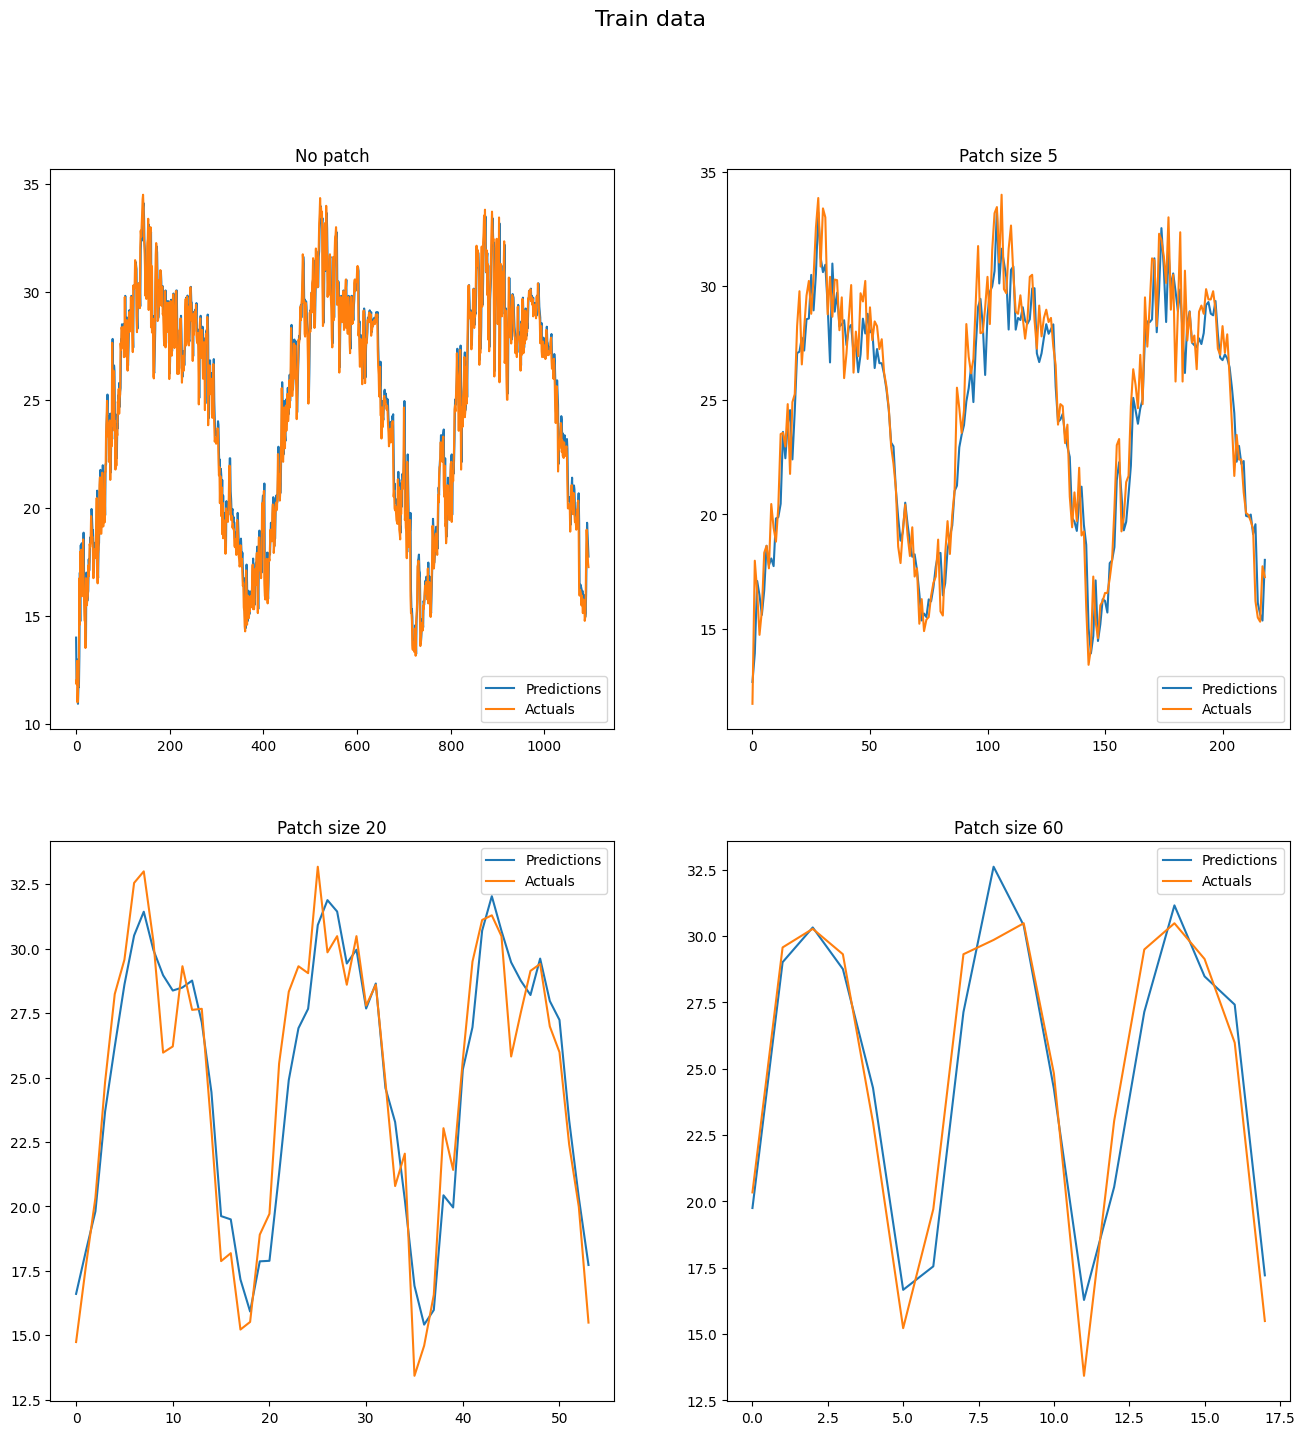

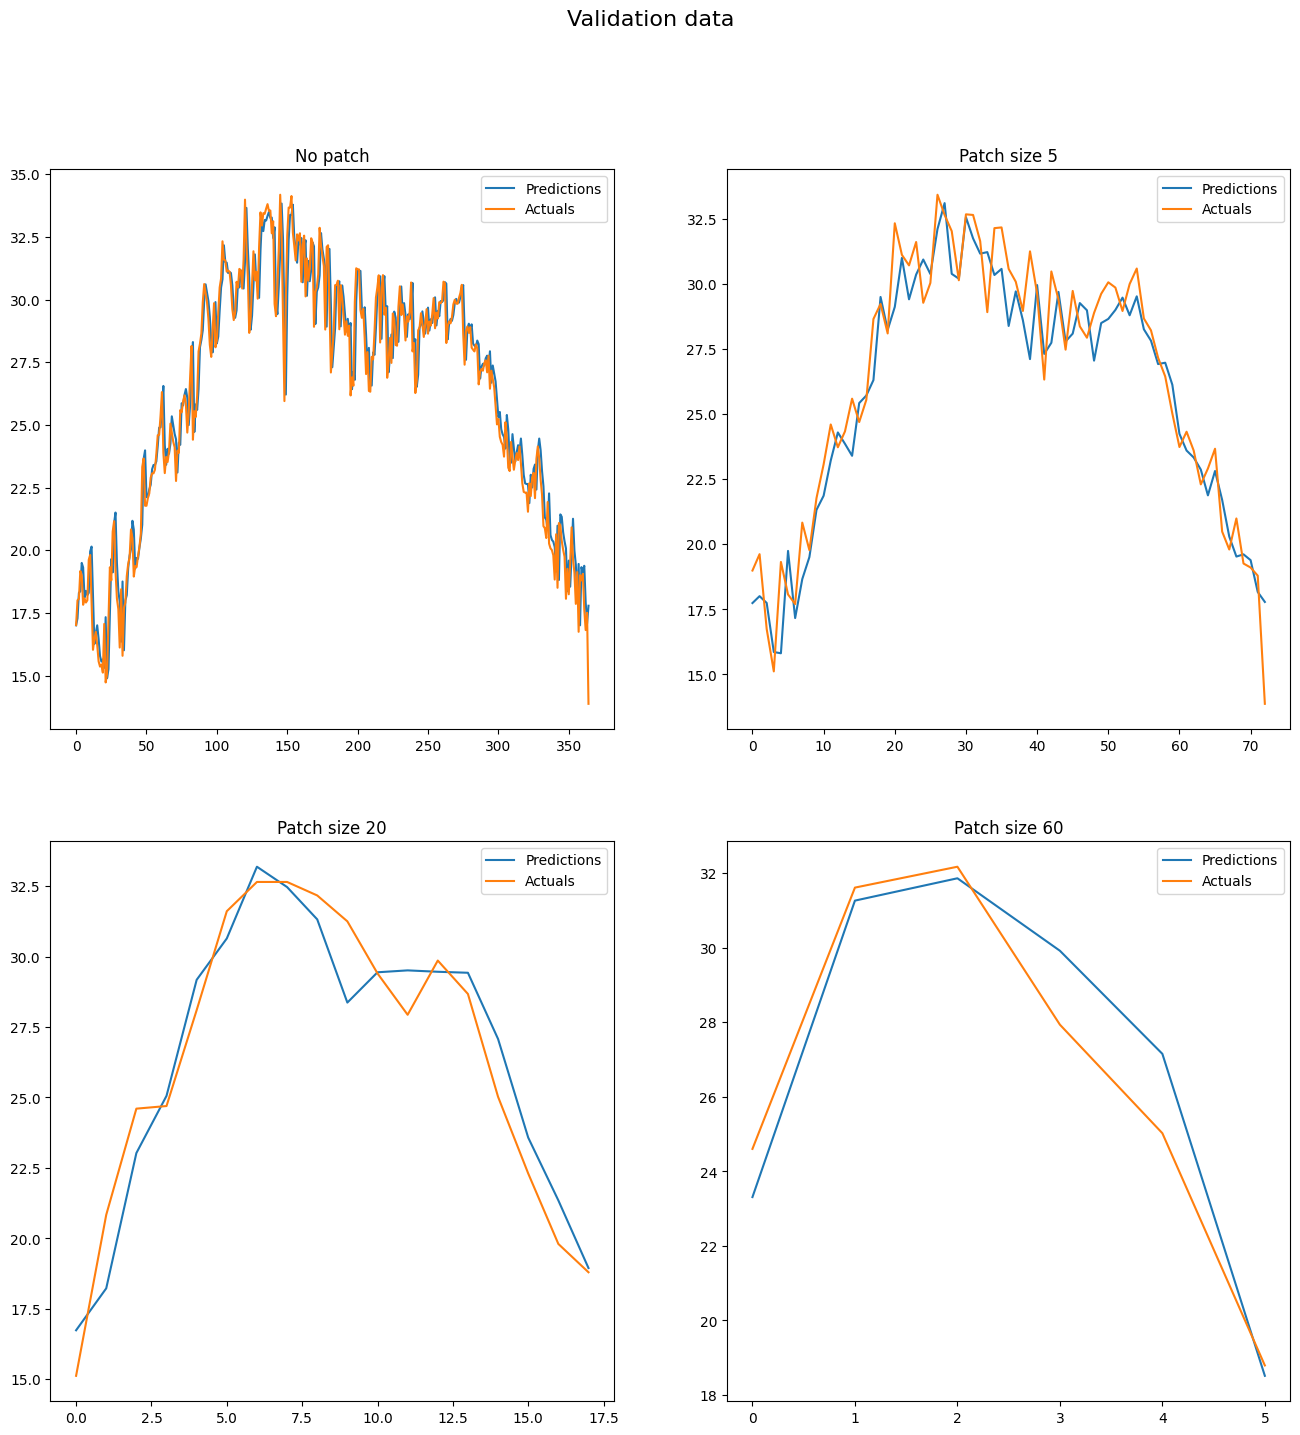

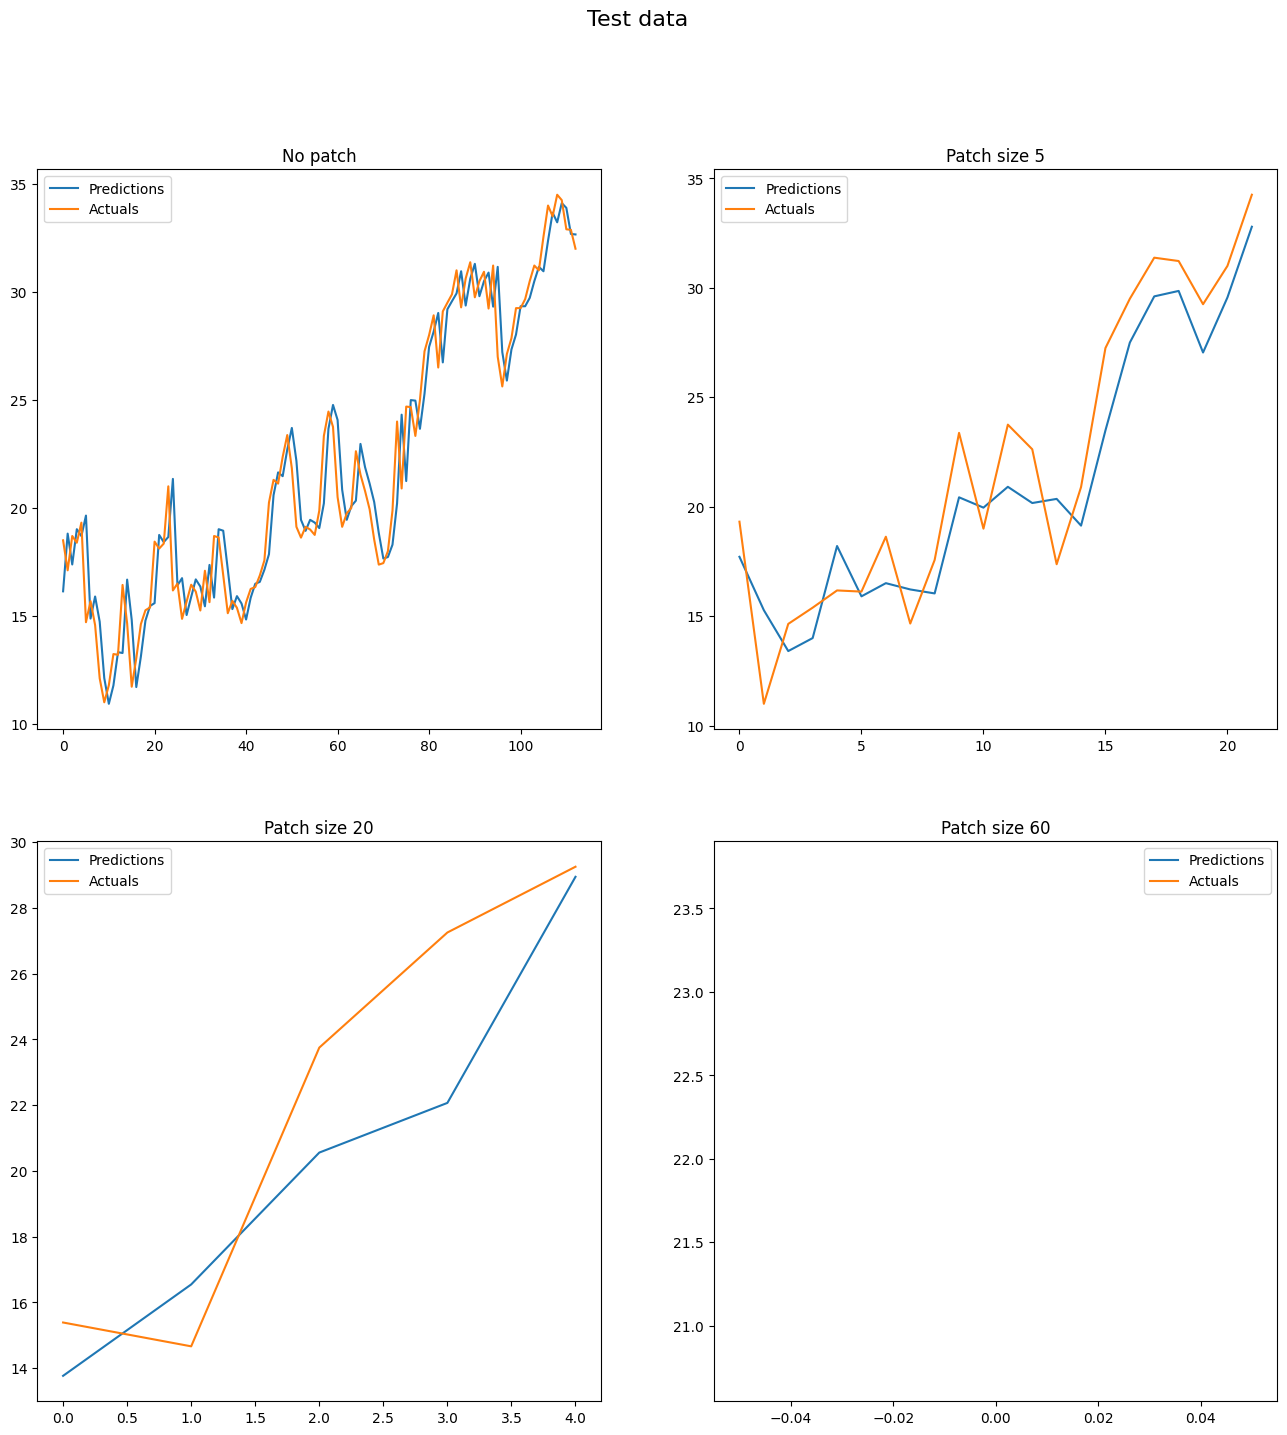

In [14]:
# plt.figure(figsize = (16, 6))
# plt.plot(preds_acts['Predictions'])
# plt.plot(preds_acts['Actuals'])
# plt.legend(['Predictions', 'Actuals'])
# plt.show()

def plotGraph(p, p5, p20, p60, title):
    fig, (axs) = plt.subplots(2, 2, figsize=(16, 16))
    # fig(figsize=(16, 16))
    axs[0, 0].plot(p['Predictions'])
    axs[0, 0].plot(p['Actuals'])
    axs[0, 0].legend(['Predictions', 'Actuals'])
    axs[0, 0].set_title("No patch")

    axs[0, 1].plot(p5['Predictions'])
    axs[0, 1].plot(p5['Actuals'])
    axs[0, 1].legend(['Predictions', 'Actuals'])
    axs[0, 1].set_title("Patch size 5")

    axs[1, 0].plot(p20['Predictions'])
    axs[1, 0].plot(p20['Actuals'])
    axs[1, 0].legend(['Predictions', 'Actuals'])
    axs[1, 0].set_title("Patch size 20")

    axs[1, 1].plot(p60['Predictions'])
    axs[1, 1].plot(p60['Actuals'])
    axs[1, 1].legend(['Predictions', 'Actuals'])
    axs[1, 1].set_title("Patch size 60")
    fig.suptitle(title, fontsize=16)
    
plotGraph(train_p, train_p5, train_p20, train_p60, "Train data")
plotGraph(val_p, val_p5, val_p20, val_p60, "Validation data")
plotGraph(test_p, test_p5, test_p20, test_p60, "Test data")
